## NHM Handwritten Text Recognition Notebook using DAN
Marko Kadic, TU Wien



In this notebook I will apply the DAN (Document Attention Network) for HTR (Handwritten Text Recognition)
of the plant images of the Vienna Natural History Museum.

Firstly I will segment the data using the following library:
    
After this I will use this pretrained model for the Handwritten Text Recognition:
<br>
DAN: a Segmentation-free Document Attention Network for Handwritten Document Recognition
<br>

https://github.com/FactoDeepLearning/DAN

The results will be comapred to the ground truth data made avaliable by the NHM that can be found
in the ground_truth_1.json file.

**1. Installing dependencies,  Preparing the data**

In [1]:
import os.path
import sys

import torch
from torch.optim import Adam
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '../DAN')

from basic.models import FCN_Encoder
from OCR.document_OCR.dan.models_dan import GlobalHTADecoder, CustomMultiHeadAttention
from OCR.document_OCR.dan.trainer_dan import Manager
from basic.utils import pad_images
from basic.metric_manager import keep_all_but_tokens

2023-09-14 13:20:18.282310: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# IMAGE PREPROCESSING FUNCTIONS
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

In [4]:
# IMAGE PREPROCESSING
import cv2
img1 = cv2.cvtColor(cv2.imread("image_samples/HND_1.jp2"), cv2.COLOR_RGBA2RGB)
img2 = cv2.cvtColor(cv2.imread("image_samples/HND_2.jp2"), cv2.COLOR_RGBA2RGB)

gray = get_grayscale(img1)
thresh = thresholding(gray)
fin1 = opening(thresh)

gray = get_grayscale(img2)
thresh = thresholding(gray)
fin2 = opening(thresh)

cv2.imwrite("image_samples/HND_1_1.jpg", fin1)
cv2.imwrite("image_samples/HND_2_1.jpg", fin2)

[ WARN:0@9.876] global /io/opencv/modules/imgcodecs/src/grfmt_jpeg2000_openjpeg.cpp (607) readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed
[ WARN:0@10.088] global /io/opencv/modules/imgcodecs/src/grfmt_jpeg2000_openjpeg.cpp (607) readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed


True

**2. Helper Functions for the DAN model**

In [2]:
class FakeDataset:

    def __init__(self, charset):
        self.charset = charset

        self.tokens = {
            "end": len(self.charset),
            "start": len(self.charset) + 1,
            "pad": len(self.charset) + 2,
        }


def get_params(weight_path):
    return {
        "dataset_params": {
            "charset": None,
        },
        "model_params": {
            "models": {
                "encoder": FCN_Encoder,
                "decoder": GlobalHTADecoder,
            },
            # "transfer_learning": None,
            "transfer_learning": {
                # model_name: [state_dict_name, checkpoint_path, learnable, strict]
                "encoder": ["encoder", weight_path, True, True],
                "decoder": ["decoder", weight_path, True, False],
            },
            "transfered_charset": True,  # Transfer learning of the decision layer based on charset of the line HTR model
            "additional_tokens": 1,  # for decision layer = [<eot>, ], only for transfered charset

            "input_channels": 3,  # number of channels of input image
            "dropout": 0.5,  # dropout rate for encoder
            "enc_dim": 256,  # dimension of extracted features
            "nb_layers": 5,  # encoder
            "h_max": 500,  # maximum height for encoder output (for 2D positional embedding)
            "w_max": 1000,  # maximum width for encoder output (for 2D positional embedding)
            "l_max": 15000,  # max predicted sequence (for 1D positional embedding)
            "dec_num_layers": 8,  # number of transformer decoder layers
            "dec_num_heads": 4,  # number of heads in transformer decoder layers
            "dec_res_dropout": 0.1,  # dropout in transformer decoder layers
            "dec_pred_dropout": 0.1,  # dropout rate before decision layer
            "dec_att_dropout": 0.1,  # dropout rate in multi head attention
            "dec_dim_feedforward": 256,  # number of dimension for feedforward layer in transformer decoder layers
            "use_2d_pe": True,  # use 2D positional embedding
            "use_1d_pe": True,  # use 1D positional embedding
            "use_lstm": False,
            "attention_win": 100,  # length of attention window
        },

        "training_params": {
            "output_folder": "dan_rimes_page",  # folder name for checkpoint and results
            "max_nb_epochs": 50000,  # maximum number of epochs before to stop
            "max_training_time": 3600 * 24 * 1.9,  # maximum time before to stop (in seconds)
            "load_epoch": "last",  # ["best", "last"]: last to continue training, best to evaluate
            "interval_save_weights": None,  # None: keep best and last only
            "batch_size": 1,  # mini-batch size for training
            "valid_batch_size": 4,  # mini-batch size for valdiation
            "use_ddp": False,  # Use DistributedDataParallel
            "ddp_port": "20027",
            "use_amp": True,  # Enable automatic mix-precision
            "nb_gpu": torch.cuda.device_count(),
            "ddp_rank": 0,
            "lr_schedulers": None,  # Learning rate schedulers
            "eval_on_valid": True,  # Whether to eval and logs metrics on validation set during training or not
            "eval_on_valid_interval": 5,  # Interval (in epochs) to evaluate during training
            "focus_metric": "cer",  # Metrics to focus on to determine best epoch
            "expected_metric_value": "low",  # ["high", "low"] What is best for the focus metric value
            "eval_metrics": ["cer", "wer", "map_cer"],  # Metrics name for evaluation on validation set during training
            "force_cpu": True,  # True for debug purposes
            "max_char_prediction": 3000,  # max number of token prediction
            # Keep teacher forcing rate to 20% during whole training
            "teacher_forcing_scheduler": {
                "min_error_rate": 0.2,
                "max_error_rate": 0.2,
                "total_num_steps": 5e4
            },
            "optimizers": {
                "all": {
                    "class": Adam,
                    "args": {
                        "lr": 0.0001,
                        "amsgrad": False,
                    }
                },
            },
        },
    }


def predict(model_path, img_paths):
    params = get_params(model_path)
    checkpoint = torch.load(model_path, map_location="cpu")
    charset = checkpoint["charset"]

    manager = Manager(params)
    manager.params["model_params"]["vocab_size"] = len(charset)
    manager.load_model()
    for model_name in manager.models.keys():
        manager.models[model_name].eval()
    manager.dataset = FakeDataset(charset)

    # format images
    imgs = [np.array(Image.open(img_path)) for img_path in img_paths]
    imgs = [np.expand_dims(img, axis=2) if len(img.shape)==2 else img for img in imgs]
    imgs = [np.concatenate([img, img, img], axis=2) if img.shape[2] == 1 else img for img in imgs]
    shapes = [img.shape[:2] for img in imgs]
    reduced_shapes = [[shape[0]//32, shape[1]//8] for shape in shapes]
    imgs_positions = [([0, shape[0]], [0, shape[1]]) for shape in shapes]
    imgs = pad_images(imgs, padding_value=0, padding_mode="br")
    imgs = torch.tensor(imgs).float().permute(0, 3, 1, 2)

    batch_data = {
        "imgs": imgs,
        "imgs_reduced_shape": reduced_shapes,
        "imgs_position": imgs_positions,
        "raw_labels": None,
    }

    with torch.no_grad():
        res = manager.evaluate_batch(batch_data, metric_names = [])
    prediction = res["str_x"]
    layout_tokens = "".join(['Ⓑ', 'Ⓞ', 'Ⓟ', 'Ⓡ', 'Ⓢ', 'Ⓦ', 'Ⓨ', "Ⓐ", "Ⓝ", 'ⓑ', 'ⓞ', 'ⓟ', 'ⓡ', 'ⓢ', 'ⓦ', 'ⓨ', "ⓐ", "ⓝ"])
    prediction = [keep_all_but_tokens(x, layout_tokens) for x in prediction]
    #print(prediction)
    return (prediction, res["confidence_score"], res["str_x"], res['coverage_vec'], res['hidden'])

**3. The Handwritten Text Recognition using DAN**

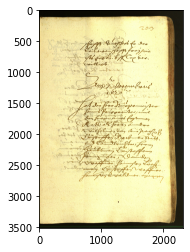

In [41]:
#plt.imshow(Image.open("../data/jp2/141114/W0003101.jp2"))
plt.imshow(Image.open("./image_samples/Seite0405.JPG"))
# display that image
plt.show()
    
model_path = "../DAN/dan_read_page.pt"

In [42]:
img = Image.open("./image_samples/Seite0405.JPG")
img_res = img.resize((290,109))
img_res.save("./image_samples/HND_1_1.jpg")

In [43]:
#img_paths = ["./image_samples/foo.jpg", "./image_samples/HND_1.jpg", "./image_samples/HND_2.jpg", "./image_samples/HND_1_1.jpg", "./image_samples/HND_2_1.jpg"]  # CHANGE WITH YOUR IMAGES PATH
    
#predictions = predict(model_path, img_paths)

#print(predictions)

In [ ]:
img_paths2 = ["./image_samples/Seite0405.JPG"]  # CHANGE WITH YOUR IMAGES PATH

#img_paths2 = ["./image_samples/HND_1_1.jpg"]  # CHANGE WITH YOUR IMAGES PATH

predictions2, confidence, raw_res, coverage_vec, hidden = predict(model_path, img_paths2)

print(predictions2[0])

full_prediction = ""

character_predictions = list(predictions2[0])
i = 0
for ch in character_predictions:
    if(ch != "\n"):
        if(confidence[0][i] >= 0.7):
            full_prediction += str(ch)
        i += 1
    
#print(len(character_predictions))
#print(len(list(confidence[0])))
print("######")
print(full_prediction)


###########
torch.Size([110, 291])


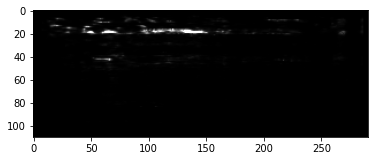

In [45]:
#print(coverage_vec)
print("###########")
#print(hidden)
print(coverage_vec[0][0].size())

import matplotlib.pyplot as plt

plt.imshow(coverage_vec[0][0][:][0:290].cpu().numpy(), cmap='gray')

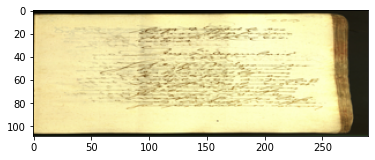

In [32]:
img = Image.open("./image_samples/Seite0405.JPG")
img_res = img.resize((290,109))

plt.imshow(img_res)
# display that image
plt.show()

In [10]:
print(raw_res[0])

ⓟⓝ8ⓃⓢⓑPon Sohgrafers Schglafers.
Ps Zimberis ind sich disen
—: 1 fl. schaamhtst. o st angest. Angester
:soll Er Schalfs. soll der Schaaffts. otc. soll Er Stain.
S: 16 k. Serstin Sp der Sts. Schlaist
.
1610. Ser St.). Srl: 16 k.
Ers Zū Berglasster Angūsters
Zū Sernsters
Zū Irsamens.
serns Zū Irsamens.
Zolgersamen
H
berin derschomen Sistorf
Hans Zū Beranimūsch
der.ⒷⓈⓅ


**4. Visualisations and results**

In [ ]:
def visualizeAttention(images):
    # format images
    imgs = [np.array(Image.open(img_path)) for img_path in img_paths]
    print("predicting")
    imgs = [np.expand_dims(img, axis=2) if len(img.shape)==2 else img for img in imgs]
    imgs = [np.concatenate([img, img, img], axis=2) if img.shape[2] == 1 else img for img in imgs]
    shapes = [img.shape[:2] for img in imgs]
    reduced_shapes = [[shape[0]//32, shape[1]//8] for shape in shapes]
    imgs_positions = [([0, shape[0]], [0, shape[1]]) for shape in shapes]
    imgs = pad_images(imgs, padding_value=0, padding_mode="br")
    imgs = torch.tensor(imgs).float().permute(0, 3, 1, 2)
    
    num_heads = 4
    model = CustomMultiHeadAttention(num_heads = 4, embed_dim = 256)
    
    weights = []
    
    for img in imgs:
        weights.append(model.forward(query = 256, key = 256, value = 256))
        
    return weights

weights = visualizeAttention(img_paths2)
print(weights)


# 5. Predict HTR on Herbarium images to compare with Tesseract

In [4]:
model_path = "../DAN/dan_read_page.pt"
model_path_rimes = "../DAN/dan_rimes_page.pt"

In [8]:
from os import listdir, walk
from os.path import isfile, join

data_path_herb = "../data/jp2/"
eval_image_files = [join(dirpath,f) for (dirpath, dirnames, filenames) in walk(data_path_herb) for f in filenames] 
eval_image_files.pop(0)

print(len(eval_image_files))

img_paths = [eval_image_files[0]]  # CHANGE WITH YOUR IMAGES PATH


1103


In [9]:
predictions, confidence, raw_res, coverage_vec, hidden = predict(model_path, img_paths)

print(predictions[0])

##################
Available GPUS: 1
Rank 0: NVIDIA A100-PCIE-40GB _CudaDeviceProperties(name='NVIDIA A100-PCIE-40GB', major=8, minor=0, total_memory=40536MB, multi_processor_count=108)
##################
Local GPU:
WORKING ON CPU !

##################
transfered weights for encoder
transfered weights for decoder
LOADED EPOCH: -1

in
98Congersargermaiserisgergermerg. genaraerg
etc. Alsersezer
Wraȳersch Pfw. farxers So sers. Als seirg Wiser Werzorgart
gers Er Merararūng Werzersamergersamer : 4. St
ardtian.
Wersiser Weis¬
wart. elc. Also 15. Fargers.


In [10]:
predictions, confidence, raw_res, coverage_vec, hidden = predict(model_path_rimes, img_paths)

print(predictions[0])

##################
Available GPUS: 1
Rank 0: NVIDIA A100-PCIE-40GB _CudaDeviceProperties(name='NVIDIA A100-PCIE-40GB', major=8, minor=0, total_memory=40536MB, multi_processor_count=108)
##################
Local GPU:
WORKING ON CPU !

##################
transfered weights for encoder
transfered weights for decoder
LOADED EPOCH: -1

in
Mme Marchette
10 rue de la Mairier
77440 CHAMETTE le 30 septembre 2006à l'Apperte d'une réponse, je vous prie, Madame, Monsieur, l'expression de mes salutations distinguées.


# EXPLORATION

In [31]:
import cv2 

imgg = cv2.cvtColor(cv2.imread("./image_samples/HND_2_4.jp2"), cv2.COLOR_RGBA2RGB)

cv2.imwrite("image_samples/HND_4_2.jpg", imgg)

[ WARN:0@16809.683] global /io/opencv/modules/imgcodecs/src/grfmt_jpeg2000_openjpeg.cpp (607) readData OpenJPEG2000: Image has unknown or unspecified color space, SRGB is assumed


True

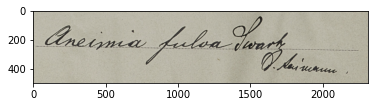

In [32]:
path_1 = "./image_samples/HND_1.jpg"
path_2 = "./image_samples/HND_2.jpg"
path_3 = "./image_samples/HND_4_2.jpg"

plt.imshow(Image.open(path_3))

# display that image
plt.show()

tests = [path_3]

In [33]:
predictions, confidence, raw_res, coverage_vec, hidden = predict(model_path, tests)

print(predictions[0])

##################
Available GPUS: 1
Rank 0: NVIDIA A100-PCIE-40GB _CudaDeviceProperties(name='NVIDIA A100-PCIE-40GB', major=8, minor=0, total_memory=40536MB, multi_processor_count=108)
##################
Local GPU:
WORKING ON CPU !

##################
transfered weights for encoder
transfered weights for decoder
LOADED EPOCH: -1

in
2E L Ersamen Schgrafer.a
sern Fernters hr. b. Anronimer. vrsamen firsterschraimen. Prererer vnd der


In [26]:
print(len(predictions[0]))
print(len(confidence[0]))


145
153


In [27]:
print(confidence[0])

[0.9997159838676453, 1.0, 0.42448973655700684, 0.6604278683662415, 0.3486327528953552, 0.7450960874557495, 0.9957491159439087, 0.9884377121925354, 0.402037650346756, 0.9662684202194214, 0.28142398595809937, 0.7197115421295166, 0.4439980685710907, 0.6241152286529541, 0.4947874844074249, 0.5440238118171692, 0.7671721577644348, 0.7586109638214111, 0.8071116805076599, 0.2154894322156906, 0.99874347448349, 0.4464655816555023, 0.8936527967453003, 0.33594703674316406, 0.43710464239120483, 0.6655287146568298, 0.9966704249382019, 0.23125021159648895, 0.4978331923484802, 0.3927967846393585, 0.4683109223842621, 0.10345130413770676, 0.19478444755077362, 0.8551117777824402, 0.8559571504592896, 0.7284478545188904, 0.8991127014160156, 0.9277414679527283, 0.5989993810653687, 0.466210275888443, 0.16665881872177124, 0.3415764272212982, 0.7353692650794983, 0.5437928438186646, 0.671513020992279, 0.7199187278747559, 0.19713684916496277, 0.21282504498958588, 0.18022242188453674, 0.23321828246116638, 0.86214